In [1]:
pip install pyserial

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for pyserial from https://files.pythonhosted.org/packages/07/bc/587a445451b253b285629263eb51c2d8e9bcea4fc97826266d186f96f558/pyserial-3.5-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 15.9 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [69]:
import sys 
print("running...")
import numpy as np
print('imported numpy')
import serial 
print('imported serial')
import time
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pylab as plt

running...
imported numpy
imported serial


In [70]:
# Open the serial port
awg = serial.Serial(
    port='/dev/ttyUSB0',       # Replace with your COM port
    baudrate=9600,
    bytesize=serial.EIGHTBITS,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    rtscts=True,  # Enable RTS/CTS (hardware handshaking),
    timeout=2
)



In [76]:
# Function to send SCPI commands
def send_command(inst, command):
    inst.write((command + '\n').encode())
    time.sleep(0.1)

# Function to query the instrument
def query_instrument(inst, command, response_return=False):
    send_command(inst, command)
    response = inst.readline().decode().strip()
    print(response)
    if response_return == True: 
        return response
    else: return 

In [72]:
query_instrument(awg, 'OUTPut:LOAD?')

9.9E37


In [73]:
send_command(awg, 'OUTPut:LOAD 10000')

In [77]:
r= query_instrument(awg, 'OUTPut:LOAD?', response_return=True)
print(r)

+1.0000000000000E+04
+1.0000000000000E+04


10000
()


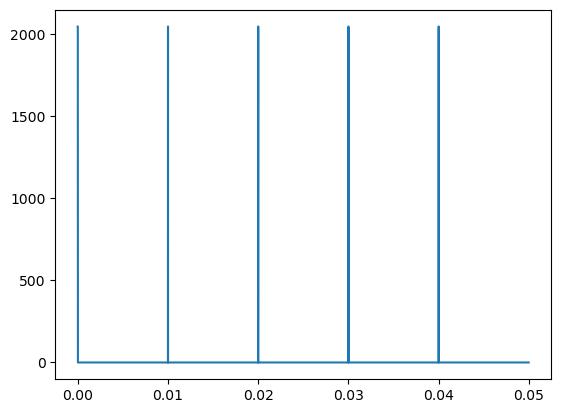

In [62]:
### THIS BLOCK WILL DEFINE A MODULATED PULSE DURATION SEQUENCE
total_duration_s = 50e-3  # 50 ms total duration
total_samples = 50000
sampling_rate = total_samples / total_duration_s #  int(sampling_rate * total_duration_ms / 1000)  # Total samples = 5000
segment_duration_ms = 10 #10 ms duration between segments
segment_samples = int(sampling_rate * segment_duration_ms / 1000)  # Samples per segment
print(segment_samples)
pulse_durations_us = [5, 7, 10, 20, 30] # Duration of each square wave in microseconds

# Define the amplitudes for each of the 5 segments
amplitudes = [1, 1, 1, 1, 1]  # Example amplitudes for the 5 segments

# Create the arbitrary waveform data
waveform_data = []
pulse_num = len(amplitudes)
for idx in range(pulse_num):
    amplitude = amplitudes[idx]
    t_us = pulse_durations_us[idx]
    # Calculate the number of points for each square wave (high and low) given t_us
    t_samples = int(sampling_rate * (t_us / 1e6))  # Convert t in microseconds to number of samples
    dac_amplitude = int(2047 * amplitude)
    # Create one segment with alternating high and low values
    high_segment = [dac_amplitude] * t_samples  # High segment for duration t
    low_segment = [0] * (segment_samples-t_samples)  # Low segment for duration t

    # Combine to form a complete segment
    segment = high_segment + low_segment
    segment = segment[:segment_samples]  # Ensure the segment is the correct length
    # Add the segment to the overall waveform
    waveform_data.extend(segment)

# Ensure total waveform length is 5000 samples
waveform_data = waveform_data[:total_samples] + [0] * (total_samples - len(waveform_data))

# Convert the waveform data to a comma-separated string
waveform_string = ','.join(f'{point:.5f}' for point in waveform_data)

print(np.shape(t_samples))
plt.plot(np.arange(total_samples)/sampling_rate, waveform_data)


In [63]:
# Reset and configure the instrument
send_command(awg, '*RST')
send_command(awg,'*CLS')
send_command(awg,'FUNC:USER VOLATILE')
send_command(awg, 'OUTPut:LOAD INFinity')

In [64]:
start_time = time.time()
send_command(awg,f'DATA:DAC VOLATILE,{waveform_string}')  # Upload arbitrary waveform
stop_time = time.time()
elapsed_time = stop_time - start_time
print(f"Time taken to download wavefunction: {elapsed_time:.6f} seconds")

Time taken to download wavefunction: 416.698558 seconds


In [65]:
send_command(awg,'FUNC USER')  # Set to arbitrary waveform mode
send_command(awg,'FUNC:USER VOLATILE')  # Select the uploaded waveform
send_command(awg,'FREQ 20')  # Set frequency to 500 Hz
send_command(awg,'VOLT 1')  # Set amplitude to 1 V
send_command(awg,'OUTP ON')  # Enable the output

In [66]:
send_command(awg,'OUTP OFF')  # Enable the output

In [58]:
query_instrument(awg, 'OUTPut:LOAD INFinity')

In [57]:
query_instrument(awg, 'SYSTem:ERRor?')

+0,"No error"


In [41]:
send_command(awg, 'DATA:DEL')

In [78]:
awg.close()